# Reuse of the trained flight controller

### The idea is to first learn a skill (e.g. flight) by imitating the real fly behavior, and then reuse this learned skill in other related tasks.

This notebook shows an example of reusing a flight controller network -- pre-trained with `flight_imitation` task -- to learn to navigate in the `vision_guided_flight` task.

We will load and freeze the weights of the pre-trained (low-level) flight controller and train another high-level controller network to steer it to solve the `vision_guided_flight` task.

# Imports

In [ ]:
import numpy as np

import tensorflow as tf
from acme import specs, wrappers
import sonnet as snt

import matplotlib.pyplot as plt
import mediapy
from tqdm import tqdm

from flybody.fly_envs import (
    flight_imitation,
    vision_guided_flight,
)
from flybody.agents.network_factory import make_network_factory_dmpo
from flybody.agents.utils_tf import TestPolicyWrapper
from flybody.agents.network_factory_vis import make_vis_network_factory_two_level_controller

# Helpful functions

In [5]:
def wrap_env(env):
    """Wrap task environment with Acme wrappers."""
    return wrappers.CanonicalSpecWrapper(
        wrappers.SinglePrecisionWrapper(env),
        clip=True)

def time_lapse(frames, num_steps=7):
    """Plot a simple time-lapse from a sequences of frames."""
    plt.figure(figsize=(14, 3))
    for i in range(num_steps):
        frame = frames[i * len(frames) // num_steps]
        plt.subplot(1, num_steps, i+1, xticks=[], yticks=[], frameon=False)
        plt.imshow(frame)
    plt.tight_layout()

render_kwargs = {'width': 640, 'height': 480}

In [2]:
# Prevent tensorflow from stealing all the GPU memory.
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Specify paths to checkpoints and the WPG base pattern

In [ ]:
wpg_pattern_path = 'path/to/wing_pattern_fmech.npy'
low_level_ckpt_path = 'path/to/low-level-controller/checkpoint'
high_level_ckpt_path = 'path/to/high-level-controller/checkpoint'

# Create environment for the vision-guided flight task

We will use the `trench` vision flight task as our example.

In [6]:
env = vision_guided_flight(
    wpg_pattern_path=wpg_pattern_path,
    bumps_or_trench='trench',
    joint_filter=0.0002,
)
env = wrap_env(env)

In [7]:
# Only in this notebook, move the "hero" camera slightly farther away.
camera = env.task.root_entity.mjcf_model.find('camera', 'walker/hero')
camera.pos *= 1.5

## Visualize the initial state of the task

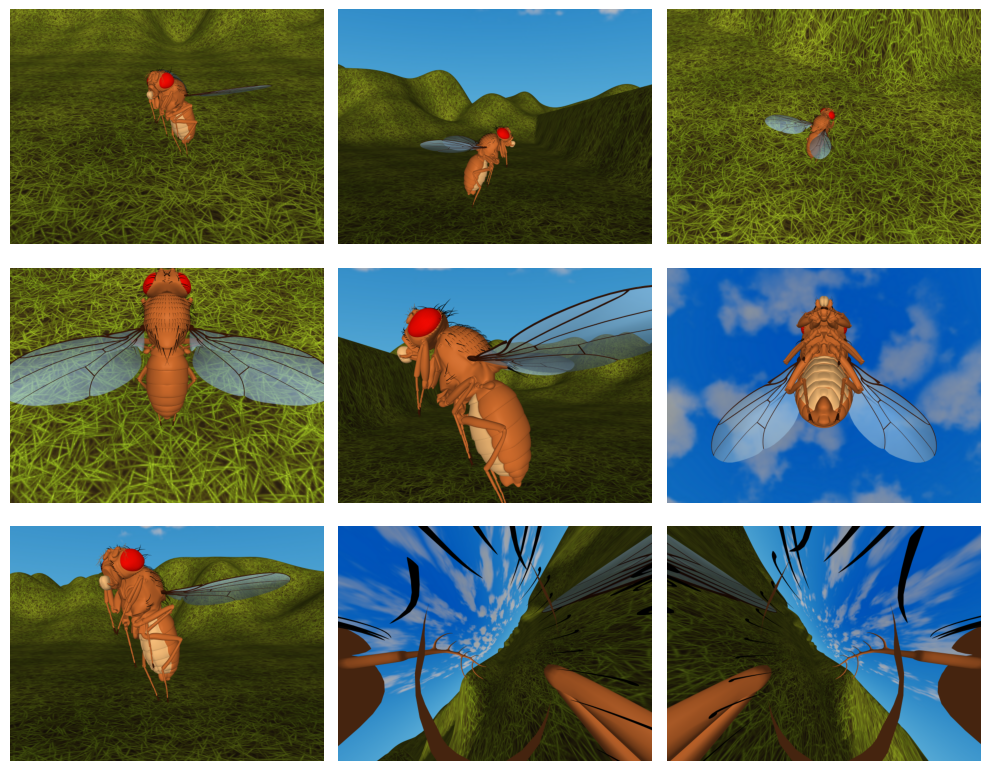

In [51]:
_ = env.reset()

plt.figure(figsize=(10, 8))
# Loop over all cameras.
for i in range(9):
    plt.subplot(3, 3, i+1, xticks=[], yticks=[], frameon=False)
    pixels = env.physics.render(camera_id=i, **render_kwargs)
    plt.imshow(pixels)
plt.tight_layout()

# Initialize the high-level and the low-level controller networks and the visual module network

### Create networks and load the weights of the pre-trained low-level controller

The following networks will be created:

1. Observation network: module to process the visual inputs from the fly's eyes
2. Policy network consisting of:
    - A high-level controller network
    - A pre-trained low-level flight controller with frozen weights
4. Critic network

Once initialized, the networks are ready for training. The pre-trained controller's weight are frozen and excluded from training.

In [52]:
# Create the same network architecture as in the flight_imitation task used to
# pre-train the low-level flight controller.
ll_network_factory = make_network_factory_dmpo()

# Also (temporarily) create the flight imitation environment to get its specs.
future_steps = 5
steering_command_dim = (future_steps + 1) * (3 + 4)
ll_env = flight_imitation(
    future_steps=future_steps,
    joint_filter=0.0002)
ll_env = wrap_env(ll_env)
ll_environment_spec = specs.make_environment_spec(ll_env)
del ll_env  # Not needed anymore.

# Create networks for the vision flight task from their network factory.
network_factory = make_vis_network_factory_two_level_controller(
    ll_network_ckpt_path=low_level_ckpt_path,
    ll_network_factory=ll_network_factory,
    ll_environment_spec=ll_environment_spec,
    hl_network_layer_sizes=(256, 256, 128),
    steering_command_dim=steering_command_dim,
    task_input_dim=2,
    vis_output_dim=8,
    critic_layer_sizes=(512, 512, 256),
)
networks = network_factory(env.action_spec())

networks.keys()

dict_keys(['policy', 'critic', 'observation'])

# Test the networks

At this point, the networks we created are ready for training, in the same way as in any other tasks (see the [train_dmpo_ray.py](https://github.com/TuragaLab/flybody/blob/main/flybody/train_dmpo_ray.py) script for example).

Below, we will just test them in action.

In [10]:
# For testing, stack the visual observation network and the two-level policy.
net_stack = snt.Sequential([
    networks['observation'],
    networks['policy'],
])
net_stack = TestPolicyWrapper(net_stack)

Except the pre-trained low-level network, the networks are not trained yet and cannot generate proper flight. We can run a test episode just to kick the tires nevertheless.

Let's run a short episode and make a video:

In [ ]:
timestep = env.reset()
frames = []
for _ in tqdm(range(200)):
    actions = net_stack(timestep.observation)
    timestep = env.step(np.zeros(12))
    frames.append(env.physics.render(camera_id=6, **render_kwargs))

In [ ]:
# Show flight video before training the high-level controller.
mediapy.show_video(frames)

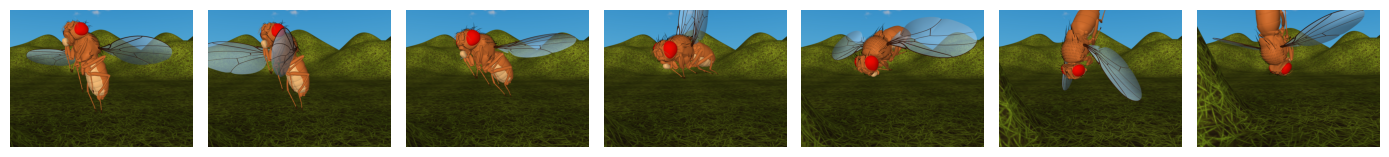

In [55]:
time_lapse(frames)

# Load the trained weights of the high-level and the visual observation networks

Let's also load the weights of the entire network stack after it's been trained and run an episode to test it

In [56]:
# This will load the weight to our `net_stack` from before.
checkpoint = tf.train.Checkpoint(
    target_policy=networks['policy'],
    target_observation=networks['observation'],
)
# For inference or reuse, we only need partial.
status = checkpoint.restore(high_level_ckpt_path).expect_partial()
status.assert_existing_objects_matched()

In [ ]:
timestep = env.reset()
frames = []
for _ in tqdm(range(500)):

    action = net_stack(timestep.observation)

    timestep = env.step(action)
    frames.append(env.physics.render(camera_id=6, **render_kwargs))

## Visualize the learned flight navigation

In [ ]:
# Show flight video after training the high-level controller.
mediapy.show_video(frames)

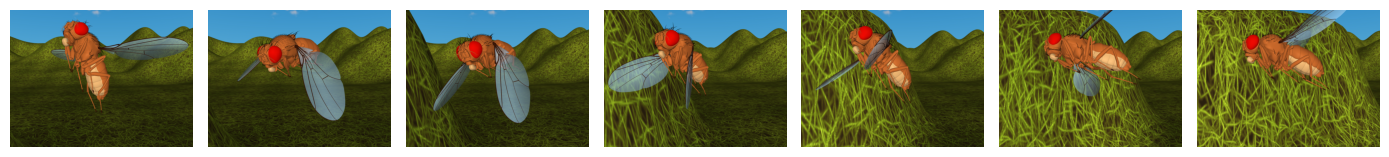

In [59]:
time_lapse(frames)